## Dog and cat image classification project 

### For this project we built Convolutional Neural Network (CNN) model from scratch as our bench mark model, and further utilized the state-of-the-art models such as VGG16 and ResNet50 as our pretrained model to perform Transfer learning on the dataset.

### We were able to visualize the loss and accuracy after each model training to observe and evaluate how the model did on our test data, from these visualization we were able to decipher how the model performed on the dataset

#### Overall we observed that for the model built from scratch and model built with transfer learning (using VGG16), the training accuracy was increasing (got to about 99% accuracy at the end of the model training) and the loss was declining in a manner that we would expect, BUT the test loss and accuracy were fluctuating. Even though, the accuracy was approximately between 98 - 99% , which is considerably good regarding our dataset but the loss wasn't decreasing as we would expect for the Test data.

#### On other hand, when we used ResNet 50 as our pretrained model for the transfer learning, these abnormalities seen in the earlier models were totally gone, even though we trained for only 5 epochs (based on my intuition), the accuracy for both the train and test data increased in a similar manner (got to about 98.5% accuracy at the end of the model evaluation) and also the loss for both dataset decreased in approximately similar manner, Nevertheless the train loss was smaller than the test loss as we would expect, but both were decreasing as the model was been trained and tested iteratively.

### Data

For this project we downloaded Cats and Dogs images inspired by the classic <a href='https://www.kaggle.com/c/dogs-vs-cats'>Kaggle competition</a>.

### Image files directory tree
<pre>.
└── data
    └── CATS_DOGS
        ├── test
        │   ├── CAT
        │   │   ├── 9374.jpg
        │   │   ├── 9375.jpg
        │   │   └── ... (3,126 files)
        │   └── DOG
        │       ├── 9374.jpg
        │       ├── 9375.jpg
        │       └── ... (3,125 files)       
        │           
        └── train
            ├── CAT
            │   ├── 0.jpg
            │   ├── 1.jpg
            │   └── ... (9,371 files)
            └── DOG
                ├── 0.jpg
                ├── 1.jpg
                └── ... (9,372 files)</pre>

## Task Ahead

* Task 1 - Importation of dataset and necessary libraries & Data Exploration
* Task 2 - Data Loading and Pre-processing
* Task 3 - Build CNN from scratch and Implementation of Model (for training and evaluation)
* Task 4 - Visualize Loss and Accuracy
* Task 5 - Build CNN using Transfer learning 1 - VGG16 & Implementation of Model (for training and evaluation)
* Task 6 - Visualize Loss and Accuracy
* Task 7 - Build CNN using Transfer learning 2 - ResNet 50 & Implementation of Model (for training and evaluation)
* Task 8 - Visualize Loss and Accuracy
* Task 9 - Summary

## Task 1 - Importation of dataset and necessary libraries & Data Exploration

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from IPython.display import display
import glob

#ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

if use_cuda:
    print('yes')

yes


In [3]:
#lets the get each category in the train and test directories

test_path = '../data/CATS_DOGS/test/'
train_path = '../data/CATS_DOGS/train/'

# Empty lists
categories = []
n_train = []
n_test = []

# Iterate through each category
for d in os.listdir(train_path):
    categories.append(d)
    #print(categories)
    
    train_img = os.listdir(train_path + d)
    #print(train_img)
    test_img = os.listdir(test_path + d)
    #print(test_img)
    n_train.append(len(train_img))
    n_test.append(len(test_img))
print(n_test, '\n', n_train)

[3125, 3126] 
 [9372, 9371]


In [5]:
# Dataframe of categories
cat_df = pd.DataFrame({'category': categories, 'n_train': n_train, 'n_test': n_test}).sort_values('category')
cat_df.head()

,category,n_train,n_test
1,CAT,9371,3126
0,DOG,9372,3125


Text(0.5,1,'Training Images by Category')

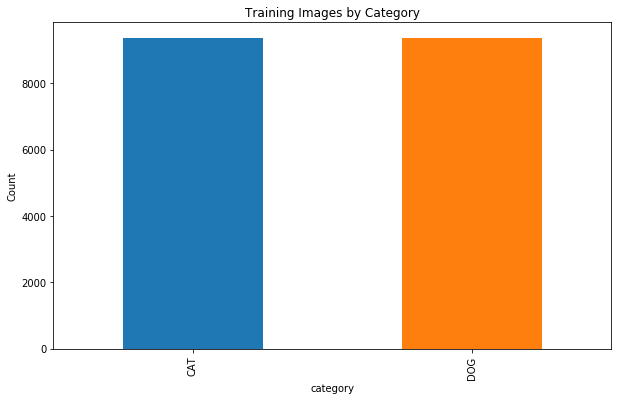

In [6]:
#we have equal samples for both cat and dog training datasets

cat_df.set_index('category')['n_train'].plot.bar( figsize=(10, 6))
plt.ylabel('Count')
plt.title('Training Images by Category')

Text(0.5,1,'Test Images by Category')

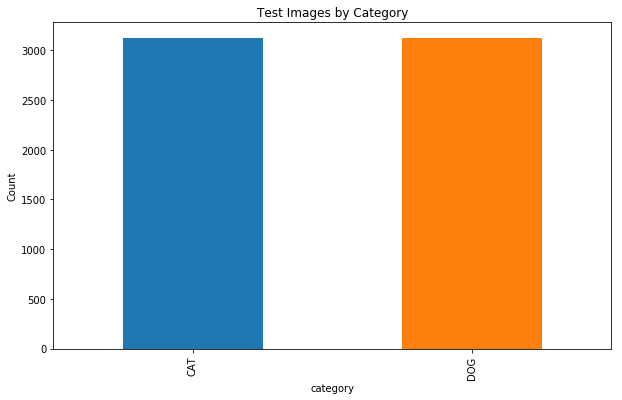

In [7]:
#we have equal datasets for both datasets

cat_df.set_index('category')['n_test'].plot.bar( figsize=(10, 6))
plt.ylabel('Count')
plt.title('Test Images by Category')

In [8]:
#lets extract the size and individual filenames of the images

def extract_img_imgsize(path):
    
    img = []
    pics = []
    
    for folder, subfolders, filenames in os.walk(path):
        for ig in filenames:
            pics.append(ig)
            img.append(folder+'/'+ig)
            
    img_sizes = []
    
    for item in img:
        with Image.open(item) as img:
            img_sizes.append(img.size)
            
    return pics, img_sizes


In [9]:
path = '../data/CATS_DOGS/'

pic_names, image_sizes = extract_img_imgsize(path)

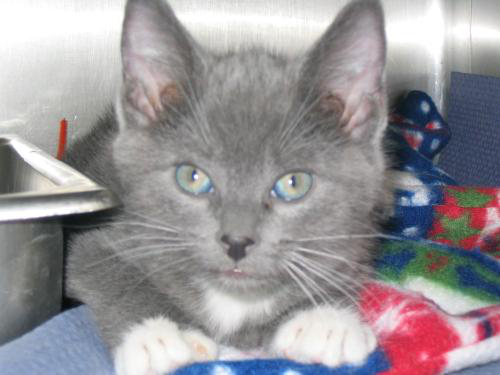

In [10]:
#lets take a look at one of the cat images

image_path = '../data/CATS_DOGS/test/CAT/'

for i in pic_names[:1]:
    images = image_path + i
    with Image.open(images) as im:
        display(im)

In [11]:
#lets know the size of our dataset

print(f'Number of images: {len(pic_names)}')

Number of images: 24994


In [12]:
#lets check the sizes of the images

df_img = pd.DataFrame(image_sizes, columns = ['width', 'height'])
df_img.head()

,width,height
0,350,286
1,500,375
2,348,500
3,500,375
4,500,375


In [13]:
#Note that the highest width and the height of the images

df_img.describe()

,width,height
count,24994.000000,24994.000000
mean,404.493518,361.037129
std,108.941802,96.936811
min,42.000000,33.000000
25%,323.000000,302.000000
50%,448.000000,375.000000
75%,500.000000,421.000000
max,500.000000,500.000000


Text(0.5,1,'Distribution of height and width across our Dataset')

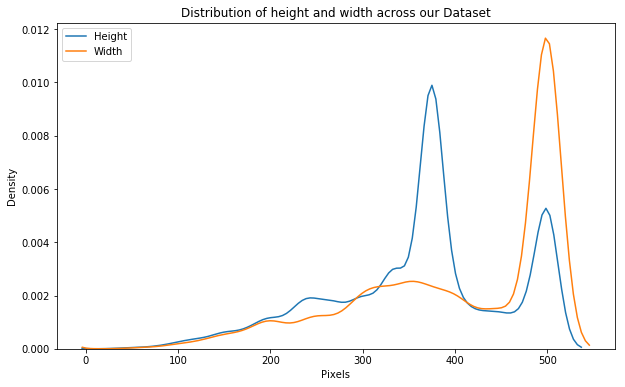

In [14]:
#Note that the width and height are highly skewed 
#this will be normalized later

plt.figure(figsize=(10, 6))
sns.kdeplot(
    df_img['height'], label='Height')
sns.kdeplot(
    df_img['width'], label='Width')
plt.xlabel('Pixels')
plt.ylabel('Density')
plt.title('Distribution of height and width across our Dataset')

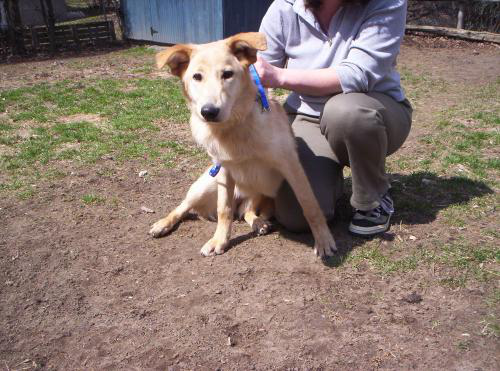

In [15]:
#lets check one of the dog images

dog = Image.open('../data/CATS_DOGS/train/DOG/22.jpg')
display(dog)

In [16]:
dog.size #height x weight

(500, 371)

In [17]:
dog.getpixel((0,0))

(34, 32, 45)

In [18]:
#convert the dog_image to tensor

transform = transforms.Compose([
    transforms.ToTensor()
])

dog_tr = transform(dog)
print(f'color_channels, width, height: {dog_tr.shape}')

color_channels, width, height: torch.Size([3, 371, 500])


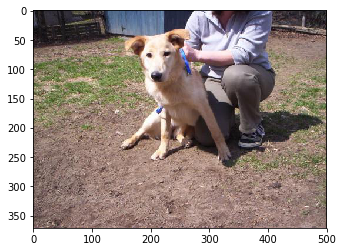

In [19]:
#note the tranpose changes theimage shape from (3 - color channel, 371 - width, 500 - height)
#to (371 - width, 500 - height, 3 - color chnannel /depth, so that matplotlib can visualize it)

plt.imshow(np.transpose(dog_tr.numpy(),(1,2,0)))

**Reason why image tensor are divided by 255?**

***The division of image pixels by 255 is applied to convert RGB pixel values which are usually in the range [0, 255] to [0.0, 1.0] range.***

***The reason they are in [0, 255] is because true color images have 256 values (8-bit) for each channel. It's common to normalize this to [0, 1] as the input to a neural network.***
***it is also necessary if you are using a pretrainednetwork from torchvision that has been trained on images with values in [0, 1] and therefore expects the same format.  [discussion on this](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning/issues/60)***

In [20]:
#pixel values have been divided by 255 #each pixel value is for each channel i.e.RGB

dog_tr[:, 0,0]

tensor([ 0.1333,  0.1255,  0.1765])

## Task 2 - Data Loading and Pre-processing

***Data pre-processing transforms our data into format that could be passed into our CNN***

***The idea of data augmentation is to artificially increase the number of training images our model sees by applying random transformations to the images.  [for details read this paper](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)***

In [21]:
# Image transformations
#Data Augmentation

train_transform = transforms.Compose([
    transforms.RandomRotation(10), # rotate +/- 10 degrees
    transforms.RandomHorizontalFlip(), # reverse 50% of images
    transforms.Resize(224), # resize shortest side to 224 pixels
    transforms.CenterCrop(224), # crop longest side to 224 pixels at center
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Test does not use augmentation

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [22]:
root = '../data/CATS_DOGS/'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform = test_transform)

train_loader = DataLoader(train_data, batch_size = 20, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 20)

class_names = train_data.classes

In [23]:
len(train_loader.dataset)

18743

In [24]:
len(test_loader.dataset)

6251

In [25]:
class_names

['CAT', 'DOG']

In [26]:
#length of the training and test data
print(f'Training size: {len(train_data)}  Test data size: {len(test_data)}')

Training size: 18743  Test data size: 6251


In [27]:
#lets get the images for one batch

for images, labels in train_loader:
    break

In [28]:
images.shape #Batch - 20, Colorchannels - 3, Width - 224, Height - 224

torch.Size([20, 3, 224, 224])

In [29]:
labels  #for one batch we have 20 labels for 20 images

tensor([ 0,  0,  0,  1,  0,  1,  1,  0,  1,  1,  0,  0,  1,  1,
         0,  0,  1,  0,  0,  1])

**Reason for performing Normalization i.e. transform.Normalize**

For image tensors with values in [0, 1] this transformation will standardize it, so that the mean of the data should be ~0 and the std ~1.

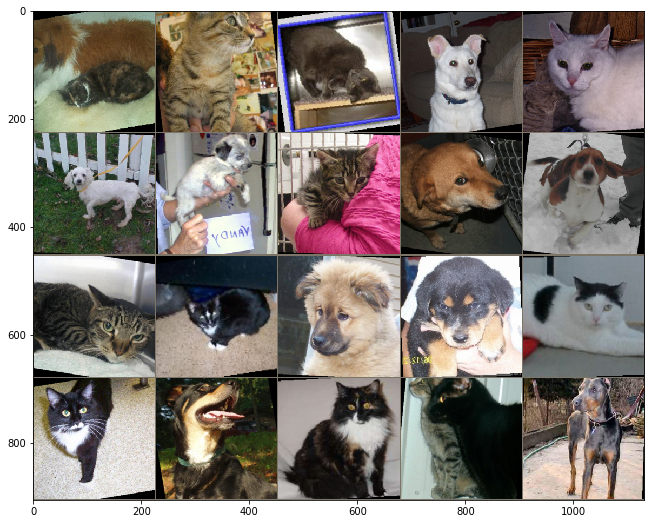

In [30]:
#lets inverse our transformation so that we can visualize our actual image

im = make_grid(images, nrow = 5)


inv_norm = transforms.Normalize(mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                               std = [1/0.229, 1/0.224, 1/0.225])

im_inv = inv_norm(im)


plt.figure(figsize=(18,9))

plt.imshow(np.transpose(im_inv.numpy(), (1,2,0)))

## Task 3 - Build CNN from scratch and Implementation of Model (for training and evaluation)

In [31]:
#The major CNN Network to be used

class ConvNetwork(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,3,1)
        self.BN1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3,1)
        self.BN2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,64,3,1)
        self.BN3 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(43264, 120) #43264 -- (((((((224-2)/2)-2)/2)-2)/2) == 26*26) * 64
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,2)
        
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(self.BN1(x))
        x = F.max_pool2d(x,2,2)
        x = self.conv2(x)
        x = F.relu(self.BN2(x))
        x = F.max_pool2d(x,2,2)
        x = self.conv3(x)
        x = F.relu(self.BN3(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1, 43264)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim = 1)
        
        return x

In [34]:
# instantiate the CNN
cnnmodel_scratch = ConvNetwork()

# move tensors to GPU if CUDA is available
if use_cuda:
    cnnmodel_scratch.cuda()

In [35]:
#lets take a look at the parameters for this model
cnnmodel_scratch

ConvNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (BN1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (BN2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (BN3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2)
  (fc1): Linear(in_features=43264, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [36]:
#lets take a look at the parameters for this model

def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item}')
    print(f'________\n{sum(params)}')

In [37]:
#Lets calculate the total sum of parameters for our model

count_parameters(cnnmodel_scratch)

432
16
16
16
4608
32
32
32
18432
64
64
64
5191680
120
10080
84
168
2
________
5225942


In [37]:
#hyperparameters for calculating cost function and computing gradient descent

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnnmodel_scratch.parameters(), lr = 0.001)

### Implementation of the model built from scratch

In [44]:
import time

def train_test(epochs, train_loader, test_loader, model, optimizer, criterion, use_cuda, save_path):
    
    start_time = time.time()
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []
    
    for i in range(epochs):
        
        trn_loss = 0
        tst_loss = 0
        trn_corr = 0
        tst_corr = 0
        
        for b, (x_train, y_train) in enumerate(train_loader):
            
            #move to GPU
            
            if use_cuda:
                x_train, y_train = x_train.cuda(), y_train.cuda()
                
            #clear the gradients
            optimizer.zero_grad()
            
            #forward pass
            y_pred = model(x_train)
            
            #find the loss
            loss = criterion(y_pred, y_train)
            
            #correlate the predictions to the actual output
            
            pred = torch.max(y_pred.data, 1)[1]
            batch_corr = (pred == y_train).sum()
            trn_corr += batch_corr
            
            #compute backpropagation
            loss.backward()
            
            #update the parameters
            optimizer.step()
            
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            trn_loss = trn_loss + ((1 / (b + 1)) * (loss.data - trn_loss))
            
        #compute average train loss
        
        trn_loss = trn_loss/len(train_loader.dataset)
            
        print(f'epoch: {i} loss: {trn_loss:7.7f} Train Accuracy: {(trn_corr.item()/len(train_loader.dataset))* 100:7.3f}%')
        
        train_losses.append(trn_loss)
        train_accuracy.append(trn_corr)
        
        #lets validate and test our model if is good good
        
        model.eval()
        
        with torch.no_grad():
            
            for b, (x_test, y_test) in enumerate(test_loader):
                
                #lets move to GPU
                
                x_test, y_test = x_test.cuda(), y_test.cuda()
                
                y_val = model(x_test)
                
                #lets predict
                prediction = torch.max(y_val.data, 1)[1]
                bach_corr = (prediction == y_test).sum()
                tst_corr += bach_corr
                
                #lets compute the cost function
                loss = criterion(y_val, y_test)
                
                tst_loss = tst_loss + ((1 / (b + 1)) * (loss.data - tst_loss))
                
        #compute average test loss
        tst_loss = tst_loss/len(test_loader.dataset)
        
        print(f'epoch:{i} loss: {tst_loss:7.7f} Test Accuracy: {(tst_corr.item()/len(test_loader.dataset)) * 100:7.3f}%')
        
        test_losses.append(tst_loss)
        test_accuracy.append(tst_corr)
        
        #Save the model if test loss decreased
        if tst_loss <= valid_loss_min:
            print(f'The best validation loss is presently: {tst_loss:.7f}. Saving model...')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = tst_loss
        
        
    total_time = time.time() - start_time
    print(f'Total_time: {total_time/60} minutes')
        
    return train_losses, test_losses, train_accuracy, test_accuracy


In [52]:
#train the model

train_loss, test_loss, train_accuracy, test_accuracy = train_test(20, train_loader, test_loader, cnnmodel_scratch, optimizer, criterion, use_cuda, 'cnnmodel.pt')

epoch: 0 loss: 0.000025 Train Accuracy:  78.040%
epoch:0 loss: 0.000070 Test Accuracy:  79.219%
The best validation loss is presently: 0.000070. Saving model...
epoch: 1 loss: 0.000023 Train Accuracy:  80.259%
epoch:1 loss: 0.000077 Test Accuracy:  76.580%
epoch: 2 loss: 0.000021 Train Accuracy:  82.271%
epoch:2 loss: 0.000064 Test Accuracy:  81.907%
The best validation loss is presently: 0.000064. Saving model...
epoch: 3 loss: 0.000020 Train Accuracy:  83.749%
epoch:3 loss: 0.000061 Test Accuracy:  83.267%
The best validation loss is presently: 0.000061. Saving model...
epoch: 4 loss: 0.000018 Train Accuracy:  85.221%
epoch:4 loss: 0.000066 Test Accuracy:  81.827%
epoch: 5 loss: 0.000017 Train Accuracy:  86.155%
epoch:5 loss: 0.000056 Test Accuracy:  84.754%
The best validation loss is presently: 0.000056. Saving model...
epoch: 6 loss: 0.000016 Train Accuracy:  87.265%
epoch:6 loss: 0.000054 Test Accuracy:  85.218%
The best validation loss is presently: 0.000054. Saving model...
epo

In [61]:
#lets transfer the outputs from our model to cpu (uncomment the code below to execute)
#test_loss = [t.cpu().numpy() for t in test_loss]
test_loss

[array(6.984895298955962e-05, dtype=float32),
 array(7.691638893447816e-05, dtype=float32),
 array(6.354210199788213e-05, dtype=float32),
 array(6.0704911447828636e-05, dtype=float32),
 array(6.64539256831631e-05, dtype=float32),
 array(5.6119271903298795e-05, dtype=float32),
 array(5.3850988479098305e-05, dtype=float32),
 array(5.270488327369094e-05, dtype=float32),
 array(6.415279494831339e-05, dtype=float32),
 array(5.1722829084610566e-05, dtype=float32),
 array(5.730912016588263e-05, dtype=float32),
 array(5.189284638618119e-05, dtype=float32),
 array(5.080740083940327e-05, dtype=float32),
 array(5.59605032321997e-05, dtype=float32),
 array(5.6092878367053345e-05, dtype=float32),
 array(5.778096237918362e-05, dtype=float32),
 array(6.381353887263685e-05, dtype=float32),
 array(5.8030982472701e-05, dtype=float32),
 array(6.163297075545415e-05, dtype=float32),
 array(5.9459278418216854e-05, dtype=float32)]

In [64]:
#lets transfer the outputs from our model to cpu
train_loss = [t.cpu() for t in train_loss]
train_loss = [t.numpy() for t in train_loss]

In [65]:
#lets transfer the accuracies to cpu and convert to numpy array

train_accuracy = [t.cpu().numpy() for t in train_accuracy]
test_accuracy = [t.cpu().numpy() for t in test_accuracy]

## Task 4 - Visualize Loss and Accuracy

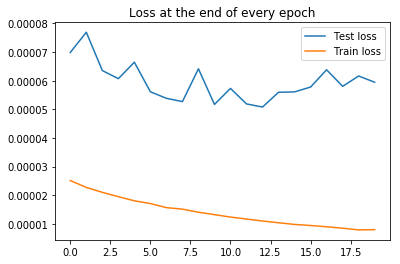

In [66]:
#visulaization
#the test loss is fluctuating.....


plt.plot(test_loss, label = 'Test loss')
plt.plot(train_loss, label = 'Train loss')
plt.title('Loss at the end of every epoch')
plt.legend()

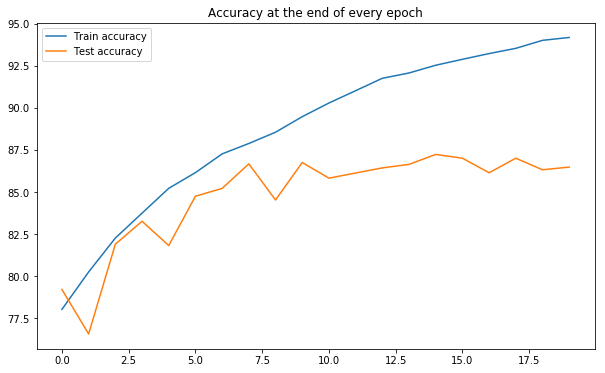

In [67]:
#the accuracy is still flunctuating needs better tuning

plt.figure(figsize=(10,6))
plt.plot([(t/len(train_loader.dataset)) * 100 for t in train_accuracy], label = 'Train accuracy')
plt.plot([(t/len(test_loader.dataset)) * 100 for t in test_accuracy], label = 'Test accuracy')
plt.title('Accuracy at the end of every epoch')
plt.legend()

### Important Notice: Since the model built from scratch is not performing well on our test data, We will try to build a new model using Transfer Learining i.e. Transfering/Applying the knowledge of a pre-trained model (i.e. one of the state-of-the-art models) to our small dog & cat classification problem.

## Task 5 - Build CNN using Transfer learning 1 - VGG16 & Implementation of Model (for training and evaluation)

## Download a pretrained model
Torchvision has a number of proven models available through <a href='https://pytorch.org/docs/stable/torchvision/models.html#classification'><tt><strong>torchvision.models</strong></tt></a>:
<ul>
<li><a href="https://arxiv.org/abs/1404.5997">AlexNet</a></li>
<li><a href="https://arxiv.org/abs/1409.1556">VGG</a></li>
<li><a href="https://arxiv.org/abs/1512.03385">ResNet</a></li>
<li><a href="https://arxiv.org/abs/1602.07360">SqueezeNet</a></li>
<li><a href="https://arxiv.org/abs/1608.06993">DenseNet</a></li>
<li><a href="https://arxiv.org/abs/1512.00567">Inception</a></li>
<li><a href="https://arxiv.org/abs/1409.4842">GoogLeNet</a></li>
<li><a href="https://arxiv.org/abs/1807.11164">ShuffleNet</a></li>
<li><a href="https://arxiv.org/abs/1801.04381">MobileNet</a></li>
<li><a href="https://arxiv.org/abs/1611.05431">ResNeXt</a></li>
</ul>
These have all been trained on the <a href='http://www.image-net.org/'>ImageNet</a> database of images. Our only task is to reduce the output of the fully connected layers from (typically) 1000 categories to just 2.

For its simplicity and effectiveness, we'll start with VGG16

### First, Obtain VGG16 model 


In [68]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

VGG16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:52<00:00, 10632821.68it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

### Freeze feature parameters
We want to freeze the pre-trained weights & biases. We set <tt>.requires_grad</tt> to False so we don't backprop through them.

In [69]:
#freeze VGG 16 feature parameters

for param in VGG16.parameters():
    param.requires_grad = False

#### Lets modify the network

***we will only fine-tune the last sequential layer***

In [72]:
VGG16.classifier = nn.Sequential(nn.Linear(25088, 1024),
                                nn.ReLU(True),
                                nn.Dropout(0.4),
                                nn.Linear(1024, 2),
                                nn.LogSoftmax(dim=1))

if use_cuda:
    VGG16 = VGG16.cuda()
    print(VGG16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [73]:
# Calculate the total number of parameters we want to train
count_parameters(VGG16)

25690112
1024
2048
2
________
25693186


In [75]:
#lets specify optimizer for the model we want to build with transfer learning

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = torch.optim.Adam(VGG16.classifier.parameters(), lr = 0.001)

In [77]:
#lets train the new model

n_epochs = 10
newtrain_loss, newtest_loss, newtrain_accuracy, newtest_accuracy = train_test(n_epochs, train_loader, test_loader, VGG16, optimizer_transfer, criterion_transfer, use_cuda, 'cnnmodel_vgg16.pt')

#load the model that got the best validation accuracy (uncomment the line below)
VGG16.load_state_dict(torch.load('cnnmodel_vgg16.pt'))

epoch: 0 loss: 0.000013 Train Accuracy:  96.970%
epoch:0 loss: 0.000007 Test Accuracy:  98.800%
The best validation loss is presently: 0.000007. Saving model...
epoch: 1 loss: 0.000002 Train Accuracy:  98.666%
epoch:1 loss: 0.000007 Test Accuracy:  98.608%
epoch: 2 loss: 0.000002 Train Accuracy:  98.848%
epoch:2 loss: 0.000008 Test Accuracy:  98.784%
epoch: 3 loss: 0.000003 Train Accuracy:  98.832%
epoch:3 loss: 0.000025 Test Accuracy:  98.480%
epoch: 4 loss: 0.000003 Train Accuracy:  99.008%
epoch:4 loss: 0.000016 Test Accuracy:  98.512%
epoch: 5 loss: 0.000002 Train Accuracy:  99.114%
epoch:5 loss: 0.000015 Test Accuracy:  98.560%
epoch: 6 loss: 0.000003 Train Accuracy:  99.184%
epoch:6 loss: 0.000035 Test Accuracy:  98.656%
epoch: 7 loss: 0.000002 Train Accuracy:  99.397%
epoch:7 loss: 0.000022 Test Accuracy:  98.608%
epoch: 8 loss: 0.000001 Train Accuracy:  99.568%
epoch:8 loss: 0.000037 Test Accuracy:  98.288%
epoch: 9 loss: 0.000002 Train Accuracy:  99.509%
epoch:9 loss: 0.000029

In [82]:
#lets transfer the outputs from our model to cpu
#uncomment the code below to execute

#newtrain_loss = [t.cpu().numpy() for t in newtrain_loss]
#newtest_loss = [t.cpu().numpy() for t in newtest_loss]

#newtrain_accuracy = [t.cpu().numpy() for t in newtrain_accuracy]
#newtest_accuracy = [t.cpu().numpy() for t in newtest_accuracy]

## Task 6 - Visualize Loss and Accuracy

### Note: Test Loss and Accuracy still fluctuating. ***Let try something new in the next section***

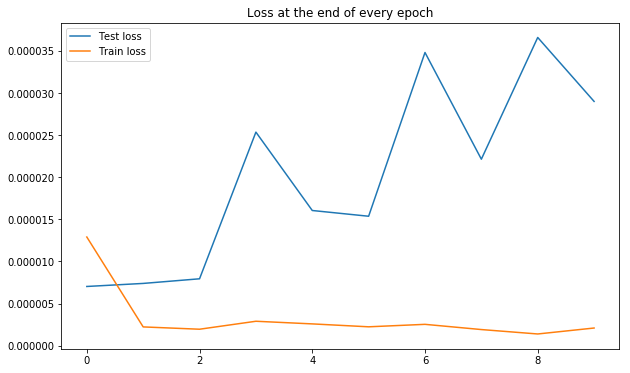

In [83]:
#the test loss is still fluctuating......

plt.figure(figsize=(10,6))
plt.plot(newtest_loss, label = 'Test loss')
plt.plot(newtrain_loss, label = 'Train loss')
plt.title('Loss at the end of every epoch')
plt.legend()

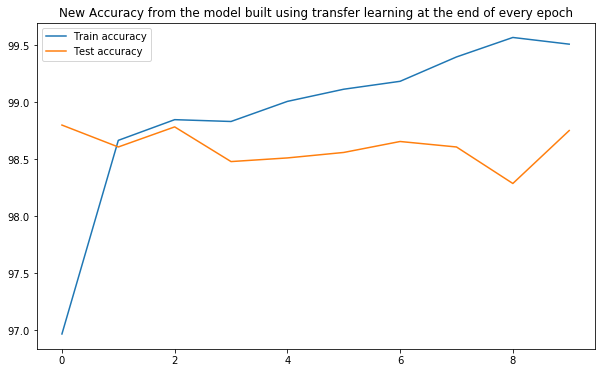

In [80]:
#the accuracy is still flunctuating needs better tuning

plt.figure(figsize=(10,6))
plt.plot([(t/len(train_loader.dataset)) * 100 for t in newtrain_accuracy], label = 'Train accuracy')
plt.plot([(t/len(test_loader.dataset)) * 100 for t in newtest_accuracy], label = 'Test accuracy')
plt.title('New Accuracy from the model built using transfer learning at the end of every epoch')
plt.legend()

## Task 7 -  Build CNN using Transfer learning 2 - ResNet 50 & Implementation of Model (for training and evaluation)

## Let's try and use the ResNet 50 pretrained network on our Data

**Note that these model may overfit to so extent on the data because of its deeper layers and also the number of classes it was intended to classify**


In [38]:
# define resnet50 model
resnet = models.resnet50(pretrained=True)

resnet

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 92867587.91it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [39]:
## Freeze resnet50 parameters 
for param in resnet.parameters():
    param.requires_grad = False

#parameters to fine-tune
resnet.fc = nn.Linear(in_features=2048, out_features=2, bias=True)

if use_cuda:
    resnet = resnet.cuda()
    print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [40]:
# Calculate the total number of parameters we want to train
count_parameters(resnet)

4096
2
________
4098


In [42]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = torch.optim.Adam(resnet.fc.parameters(), lr = 0.001)

In [46]:
n_epochs = 5
newtrain_loss, newtest_loss, newtrain_accuracy, newtest_accuracy = train_test(n_epochs, train_loader, test_loader, resnet, optimizer_transfer, criterion_transfer, use_cuda, 'cnnmodel_resnet.pt')

#load the model that got the best validation accuracy
resnet.load_state_dict(torch.load('cnnmodel_resnet.pt'))

epoch: 0 loss: 0.0000056 Train Accuracy:  95.956%
epoch:0 loss: 0.0000094 Test Accuracy:  97.760%
The best validation loss is presently: 0.0000094. Saving model...
epoch: 1 loss: 0.0000022 Train Accuracy:  98.447%
epoch:1 loss: 0.0000061 Test Accuracy:  98.576%
The best validation loss is presently: 0.0000061. Saving model...
epoch: 2 loss: 0.0000020 Train Accuracy:  98.613%
epoch:2 loss: 0.0000064 Test Accuracy:  98.464%
epoch: 3 loss: 0.0000022 Train Accuracy:  98.527%
epoch:3 loss: 0.0000059 Test Accuracy:  98.576%
The best validation loss is presently: 0.0000059. Saving model...
epoch: 4 loss: 0.0000020 Train Accuracy:  98.682%
epoch:4 loss: 0.0000060 Test Accuracy:  98.512%
Total_time: 30.38387342294057 minutes


### Note that I only trained the model (built using ResNet 50 architecture) for 5 epochs because I realized that limiting the amount of epochs on both train and test data is better to achieve quite a reasonable accuracy and avoid fluctuations.  ##Based on my intuition

In [47]:
#lets move all the accuracies and loss to CPU

newtrain_loss = [t.cpu().numpy() for t in newtrain_loss]
newtest_loss = [t.cpu().numpy() for t in newtest_loss]

newtrain_accuracy = [t.cpu().numpy() for t in newtrain_accuracy]
newtest_accuracy = [t.cpu().numpy() for t in newtest_accuracy]

## Task 7 - Visualize Loss and Accuracy

### FINALLY; No more test loss and accuracy fluctuation

### Nevertheless, there is room for Improvement

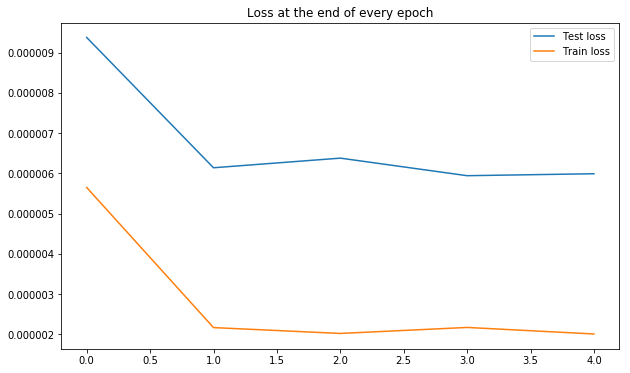

In [48]:
#finally no more fluctuation on the test loss

plt.figure(figsize=(10,6))
plt.plot(newtest_loss, label = 'Test loss')
plt.plot(newtrain_loss, label = 'Train loss')
plt.title('Loss at the end of every epoch')
plt.legend()

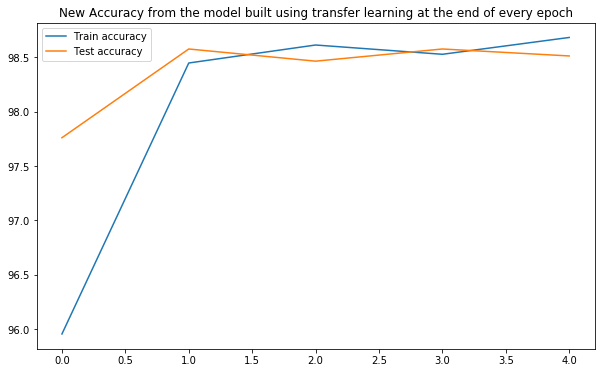

In [49]:
#No more fluctuations

plt.figure(figsize=(10,6))
plt.plot([(t/len(train_loader.dataset)) * 100 for t in newtrain_accuracy], label = 'Train accuracy')
plt.plot([(t/len(test_loader.dataset)) * 100 for t in newtest_accuracy], label = 'Test accuracy')
plt.title('New Accuracy from the model built using transfer learning at the end of every epoch')
plt.legend()

## Summary 

1. This project was aimed towards understanding the role of transfer learning in building models for specific image classification problems based on the already established state-of-the-art problem.
2. Data exploration was done to enabled us to check for data imbalance and further examine the distribution of the cat and dog images in our dataset.
3. Data loading and pre-processing was done to transform the dataset to the appropriate format required by the CNN.
4. Our model built from scratch, had the training accuracy and the loss behaving in a manner we would expect i.e. accuracy increasing to about 98% accuracy, and loss decreasing to about 0.000006 loss, however the test loss was undergoing fluctuations, even though its accuracy was also good (about 98% after the last evaluation) it was NOT convincing, it felt that it hasn't stabilized or converged.
5. Our model built using VGG16 as the pre-trained network also had similar problems, in which the test accuracy and loss was also fluctuating.
6. To wrap it up, We further built the model using ResNet 50 as our pre-trained model, and this instantenously gave us what we had intended for within 5 epochs of training and evaluation. 

- Nonetheless, there is inexhaustive room for improvenment for this project, for example, we could have tuned the hyperparameters more closely, but this would require the availability of GPU which is not readily available for the tuning and tweaking of hyperparameters that would take a longer time than expected.

- Overall, ResNet 50 showed its power and capability in transfering its knowledge from the ImageNet classification challenge to our small image classification problem with minimal overfitting on the training data.